# Stock-Market-Index-Price-Prediction

### Final Project for Introduction to Deep Learning Course at University of South Florida
### Team Members: Jun Kim, Gerardo Wibmer Gonzalez, Paul-Ann Francis, Tahsun Rahman Khan

## Overview
This project aims to predict the closing prices of stock market indices using deep learning models built with Python and TensorFlow. We have developed a two-model approach to achieve this goal. The first model (Model 1) predicts the closing price using four input features (Open, High, Low, and Volume) for a specific date. The second model (Model 2) predicts the future values of each feature based on their respective historical data. By combining the predictions from these two models, we can estimate the closing price for any given day.

Although our project focuses on predicting the S&P 500 index prices, the code can be easily modified to predict the prices of any stock.

## Data
The data used in this project consists of daily stock market index prices, including Open, High, Low, Close, and Volume. We have used the historical price data of the S&P 500 index, obtained from Yahoo Finance, to train, validate, and test our models.

## Approach
1. Preprocessing: The raw data is preprocessed to create a windowed dataset, which includes the necessary features and target variables.
2. Model Training: We train separate instances of Model 2 for each feature (Open, High, Low, and Volume) using their historical data. This results in four different models that predict future values for each feature. Then, we train Model 1 using the combined features from Model 2's predictions.
3. Hyperparameter Tuning: We used grid search to find the best hyperparameters for our models. The optimal hyperparameters and their corresponding performance metrics are stored in CSV files under the hyperparameters/ directory.
4. Prediction: We input the predicted values of Open, High, Low, and Volume from Model 2 into Model 1 to predict the closing price for any given day.

## Repository Structure
- models/: Contains the saved deep learning models (Model 1 and Model 2 instances) for each feature.
- hyperparameters/: Contains CSV files with the optimal hyperparameters and their corresponding performance metrics, obtained through grid search.
- notebooks/: Contains Jupyter notebooks for data preprocessing, model training, and evaluation.
- README.md: Provides an overview of the project, including the approach, data, and repository structure.

## Dependencies
- Python 3.8 or higher
- datetime
- matplotlib
- NumPy
- pandas
- scikit-learn
- TensorFlow
- Keras
- yfinance

## License
This project is licensed under the Apache License 2.0. See LICENSE file for details.

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import GridSearchCV, train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LeakyReLU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.keras.regularizers as regularizers
import yfinance as yf

# Preprocessing

In [2]:
TRAIN_START_DATE = '1960-01-01'
TRAIN_END_DATE = '2015-12-31'
PREDICT_START_DATE = '2016-01-01'
PREDICT_END_DATE = '2019-12-31'
WINDOW_SIZE = 7

In [3]:
# Download S&P 500 data from Yahoo Finance
df = yf.download('^GSPC', start=TRAIN_START_DATE, end=PREDICT_END_DATE)

df = df.reset_index()

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
df['Date'] = df['Date'].apply(str_to_datetime)

df.index = df.pop('Date')

# Drop columns that are not needed
df = df.drop(columns=['Adj Close'])
df = df.drop(columns=['Volume'])

# Create actual close df for plotting
actual_close_df = df['Close']

[*********************100%***********************]  1 of 1 completed


In [4]:
# Split data into train and test sets
X_train = df[:PREDICT_START_DATE]
X_test = df[PREDICT_START_DATE:PREDICT_END_DATE]
y_train = X_train.pop('Close')
y_test = X_test.pop('Close')

In [5]:
date_df_all = df.index
date_df_train = y_train.index
date_df_test = y_test.index

# Model 1

In [6]:
class CreateModel:
    def __init__(self, feature, dates, X_train, y_train, window_size, params=None):
        self.feature = feature
        self.dates = dates
        self.X = X_train
        self.y = y_train
        self.window_size = window_size
        self.params = params

        if self.params is None:
            self.best_model = self.train_model(True)
        else:
            self.best_model = self.train_model(False)

    def create_model(
        self,
        lstm_units=64,
        dense_units=32,
        learning_rate=0.001,
        lstm_activation="tanh",
        dense_activation="relu",
        lstm_regularizer=None,
        dense_regularizer=None,
    ):
        model = Sequential(
            [
                Input((3, 1)),
                LSTM(
                    lstm_units,
                    activation=lstm_activation,
                    kernel_regularizer=lstm_regularizer,
                ),
            ]
        )

        if dense_activation == "leaky_relu":
            model.add(
                Dense(
                    dense_units,
                    kernel_regularizer=dense_regularizer,
                )
            )
            model.add(LeakyReLU(alpha=0.3))
            model.add(
                Dense(
                    dense_units,
                    kernel_regularizer=dense_regularizer,
                )
            )
            model.add(LeakyReLU(alpha=0.3))
        else:
            model.add(
                Dense(
                    dense_units,
                    activation=dense_activation,
                    kernel_regularizer=dense_regularizer,
                )
            )
            model.add(
                Dense(
                    dense_units,
                    activation=dense_activation,
                    kernel_regularizer=dense_regularizer,
                )
            )
            model.add(Dense(1))

        model.compile(
            loss="mse",
            optimizer=Adam(learning_rate=learning_rate),
            metrics=["mean_absolute_error"],
        )

        return model

    def train_model(self, grid_search):
        # Check if GPU is available
        if tf.config.list_physical_devices("GPU"):
            print("Using GPU")
            # Set the device to GPU:0
            with tf.device("/GPU:0"):
                best_model = self.train_model_helper(grid_search)
        else:
            print("Using CPU")
            # If GPU is not available, perform grid search on CPU
            best_model = self.train_model_helper(grid_search)

        return best_model

    def train_model_helper(self, grid_search):
        # Wrap the create_model function with KerasRegressor
        model = KerasRegressor(build_fn=self.create_model, verbose=1)

        # Define the grid search parameters
        param_grid = {
            "lstm_units": [8, 16, 32],
            "dense_units": [4, 8, 16],
            "learning_rate": [0.0001, 0.001],
            "epochs": [10, 30],
            "batch_size": [8, 16],
            "lstm_activation": ["tanh", "relu", "leaky_relu"],
            "dense_activation": ["relu", "elu"],
            "lstm_regularizer": [
                tf.keras.regularizers.l1(0.01),
                tf.keras.regularizers.l2(0.01),
                tf.keras.regularizers.l1_l2(0.01),
            ],
            "dense_regularizer": [
                tf.keras.regularizers.l1(0.01),
                tf.keras.regularizers.l2(0.01),
                tf.keras.regularizers.l1_l2(0.01),
            ],
        }

        # Create the GridSearchCV object
        grid = GridSearchCV(
            estimator=model, param_grid=param_grid, n_jobs=-30, cv=2, verbose=1
        )

        # Split the data into training and validation
        q_80 = int(len(self.dates) * 0.8)

        self.dates_train, X_train, y_train = (
            self.dates[:q_80],
            self.X[:q_80],
            self.y[:q_80],
        )
        self.dates_val, X_val, y_val = self.dates[q_80:], self.X[q_80:], self.y[q_80:]

        if grid_search:
            # Perform grid search
            grid_result = grid.fit(X_train, y_train)

            # Print the best hyperparameters
            print(
                "Best score: %f using %s"
                % (grid_result.best_score_, grid_result.best_params_)
            )

            # Create a model with the best hyperparameters
            best_params = grid_result.best_params_

            # Save the best hyperparameters
            best_params_df = pd.DataFrame(best_params, index=[0])
            best_params_df.to_csv(f"{self.feature}_best_params.csv", index=False)

            best_epochs = best_params.pop("epochs")
            best_batch_size = best_params.pop("batch_size")
            best_model = self.create_model(**best_params)
        else:
            print("Using best hyperparameters from previous run")
            best_epochs = self.params.pop("epochs")
            best_batch_size = self.params.pop("batch_size")
            print(self.params)
            best_model = self.create_model(**self.params)

        # Train the best model with the training data using default batch_size and epochs
        history = best_model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=best_epochs,
            batch_size=best_batch_size,
        )
        self.print_metrics(history)
        self.plot_learning_curves(history)

        return best_model

    def print_metrics(self, history):
        # Get the training and validation loss and mean absolute error (MAE) from history
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        train_mae = history.history["mean_absolute_error"]
        val_mae = history.history["val_mean_absolute_error"]

        # Calculate the final MSE and MAE for training and validation
        final_train_mse = train_loss[-1]
        final_val_mse = val_loss[-1]
        final_train_mae = train_mae[-1]
        final_val_mae = val_mae[-1]

        # Print the results
        print("Training metrics:")
        print(f"MSE: {final_train_mse}, MAE: {final_train_mae}")
        print("Validation metrics:")
        print(f"MSE: {final_val_mse}, MAE: {final_val_mae}")

    def plot_learning_curves(self, history):
        # Get the training and validation loss and mean absolute error (MAE) from history
        train_loss = history.history["loss"]
        val_loss = history.history["val_loss"]
        train_mae = history.history["mean_absolute_error"]
        val_mae = history.history["val_mean_absolute_error"]

        # Get the number of epochs
        epochs = range(1, len(train_loss) + 1)

        # Plot the training and validation loss
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_loss, "r", label="Training Loss")
        plt.plot(epochs, val_loss, "b", label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.show()

        # Plot the training and validation MAE
        plt.figure(figsize=(12, 6))
        plt.plot(epochs, train_mae, "r", label="Training MAE")
        plt.plot(epochs, val_mae, "b", label="Validation MAE")
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error")
        plt.legend()
        plt.title("Training and Validation Mean Absolute Error")
        plt.show()

In [7]:
def parse_regularizer(reg_str):
    # A regex pattern to match the regularizer type and value from the string.
    pattern = r"tf.keras.regularizers.(\w+)\(([\d\.]+)\)"
    match = re.match(pattern, reg_str)
    if match:
        # The type of the regularizer is the first group in the match.
        reg_type = match.group(1)
        # The value of the regularizer is the second group in the match.
        reg_value = float(match.group(2))
        if reg_type == "l1":
            return regularizers.l1(reg_value)
        elif reg_type == "l2":
            return regularizers.l2(reg_value)
        elif reg_type == "l1_l2":
            return regularizers.l1_l2(l1=reg_value, l2=reg_value)
    else:
        raise ValueError(f"Unknown regularizer: {reg_str}")

Using GPU
Metal device set to: Using best hyperparameters from previous run
{'dense_activation': 'elu', 'dense_regularizer': <keras.regularizers.L2 object at 0x287fd63a0>, 'dense_units': 8, 'learning_rate': 0.001, 'lstm_activation': 'relu', 'lstm_regularizer': <keras.regularizers.L2 object at 0x287fd0dc0>, 'lstm_units': 32}
Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-30 11:43:12.189359: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
/var/folders/3g/0l7bk23d0116yj_4z59psh_c0000gn/T/ipykernel_5443/3753390471.py:92: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=self.create_model, verbose=1)
2023-04-30 11:43:12.189857: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-04-30 11:43:12.546710: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-30 11:43:13.061869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - ETA: 0s - loss: 7534.8325 - mean_absolute_error: 15.9281

2023-04-30 11:44:07.920928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1410/1410 [==============================] - 61s 43ms/step - loss: 7534.8325 - mean_absolute_error: 15.9281 - val_loss: 55.1640 - val_mean_absolute_error: 5.4307
Epoch 2/10
1410/1410 [==============================] - 58s 41ms/step - loss: 25.1059 - mean_absolute_error: 2.3131 - val_loss: 86.8453 - val_mean_absolute_error: 7.4698
Epoch 3/10
1410/1410 [==============================] - 57s 40ms/step - loss: 23.4240 - mean_absolute_error: 2.4121 - val_loss: 159.6933 - val_mean_absolute_error: 11.0608
Epoch 4/10
1410/1410 [==============================] - 58s 41ms/step - loss: 30.5618 - mean_absolute_error: 2.7533 - val_loss: 84.7353 - val_mean_absolute_error: 6.5464
Epoch 5/10
1410/1410 [==============================] - 58s 41ms/step - loss: 31.1556 - mean_absolute_error: 2.8523 - val_loss: 208.2414 - val_mean_absolute_error: 12.1504
Epoch 6/10
1410/1410 [==============================] - 57s 41ms/step - loss: 35.2961 - mean_absolute_error: 3.0231 - val_loss: 75.9616 - val_mean_absolut

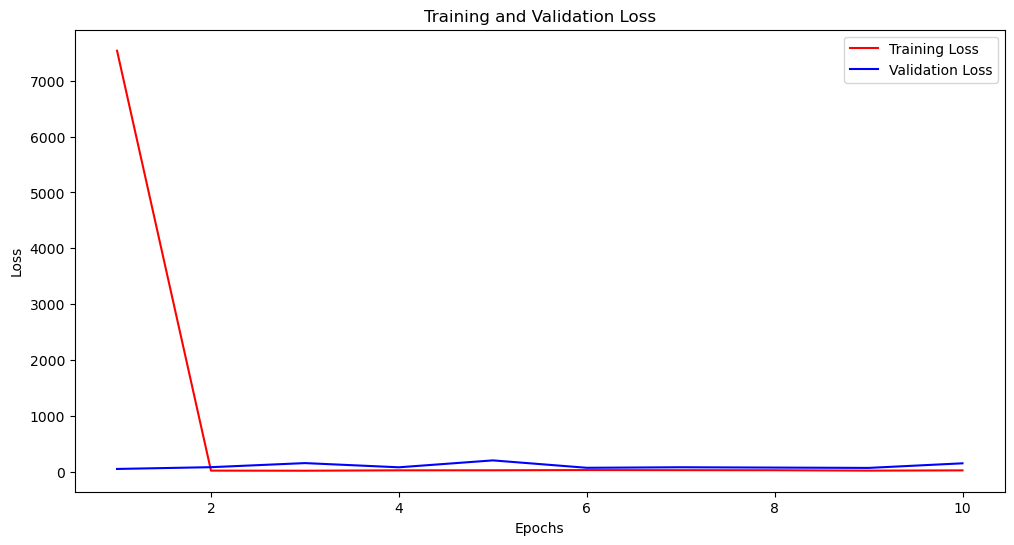

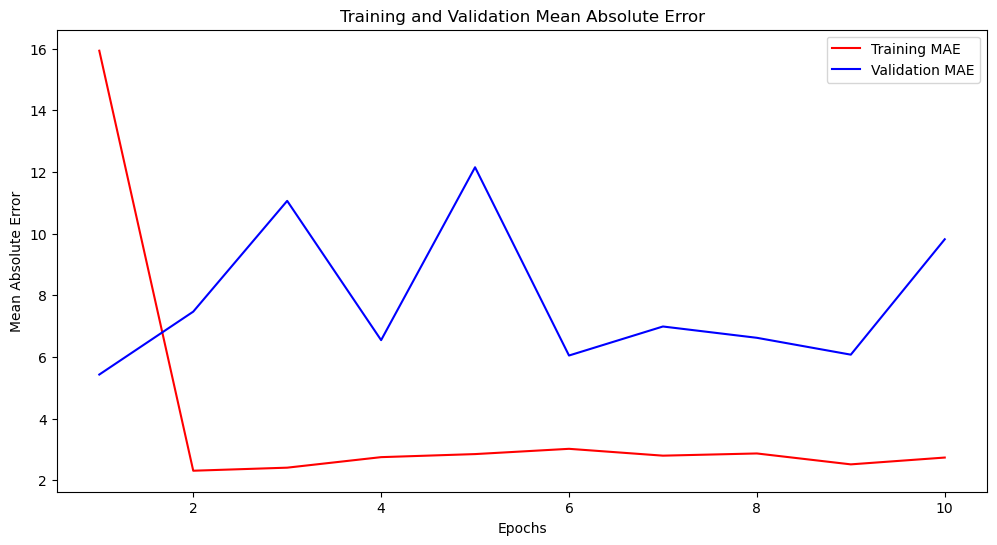

In [8]:
model1_params = pd.read_csv('../hyperparameters/Model1_best_params.csv').to_dict(orient='records')[0]

# Convert regularizer strings to actual regularizer instances.
model1_params['dense_regularizer'] = parse_regularizer(model1_params['dense_regularizer'])
model1_params['lstm_regularizer'] = parse_regularizer(model1_params['lstm_regularizer'])

close_model = CreateModel('Open', date_df_train, X_train, y_train, WINDOW_SIZE, params=model1_params)

## Predict from model 2
This is the prediction using X_test which is a dataframe directly from the model 2 predictions. This means that X_test is an array with ['Open', 'High', 'Low', 'Volume'] but using predictions from model 2, not the real observed data. 

In [32]:
# Read model 2 predictions from csv
open_predictions = np.genfromtxt('../predictions/open_predictions.csv', delimiter=',').reshape(-1, 1)
high_predictions = np.genfromtxt('../predictions/high_predictions.csv', delimiter=',').reshape(-1, 1)
low_predictions = np.genfromtxt('../predictions/low_predictions.csv', delimiter=',').reshape(-1, 1)

In [33]:
# Concatenate predictions into one dataframe
model2_predictions = np.concatenate([open_predictions, high_predictions, low_predictions], axis=1)

In [34]:
# Make predictions
close_predictions = close_model.best_model.predict(model2_predictions).flatten()

32/32 [==============================] - 0s 11ms/step


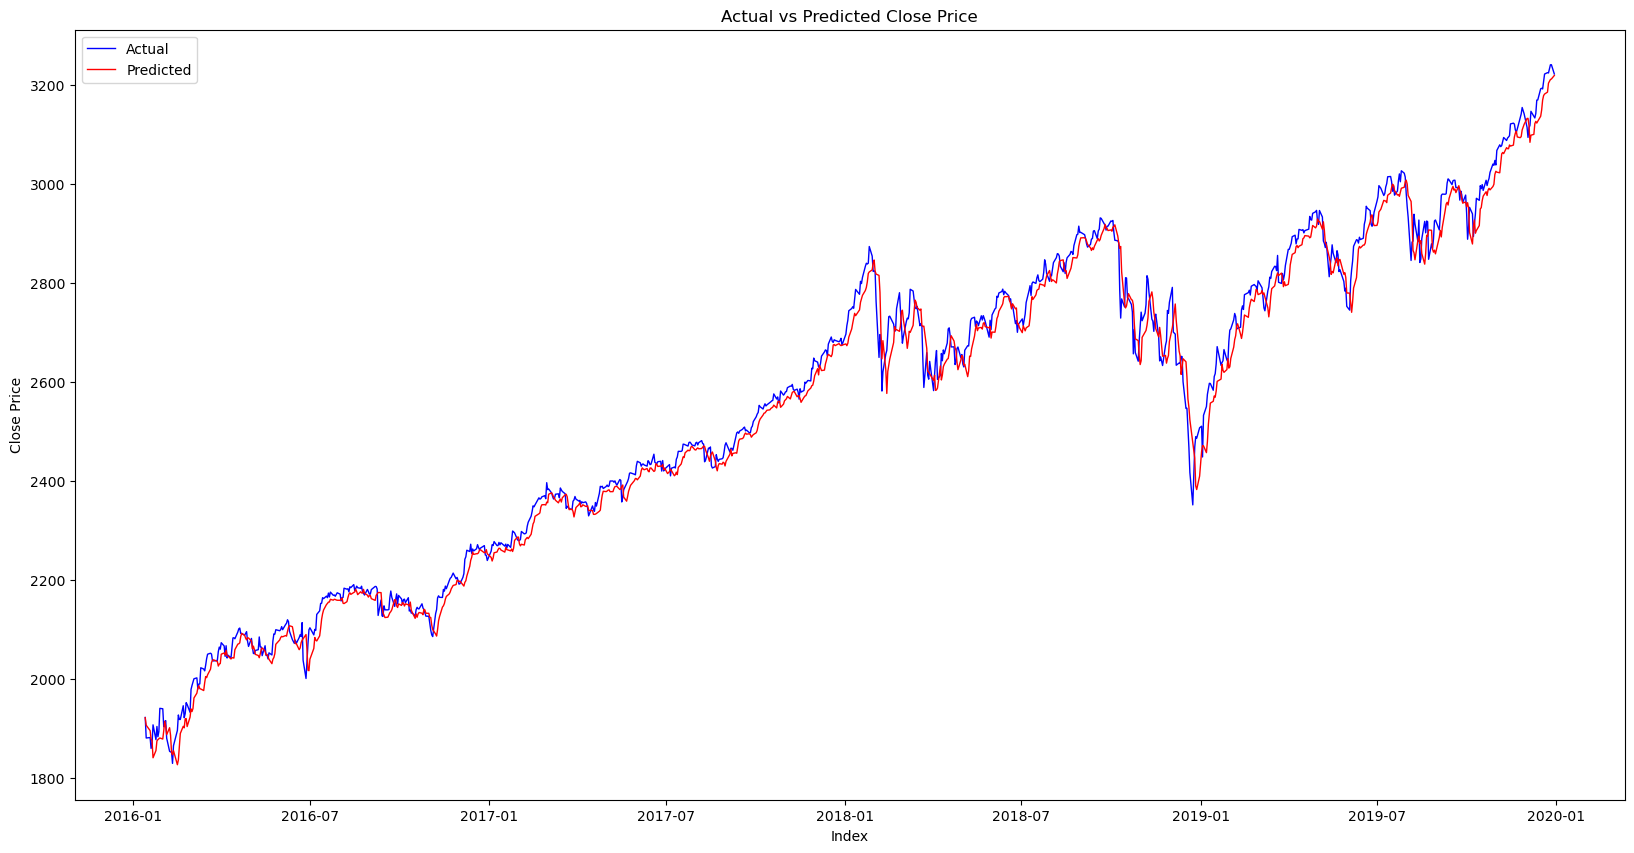

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.plot(y_test.index[8:], y_test[8:], 'b-', label='Actual', linewidth=1)
plt.plot(y_test.index[8:], close_predictions, 'r-', label='Predicted', linewidth=1)
plt.legend()
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.show()


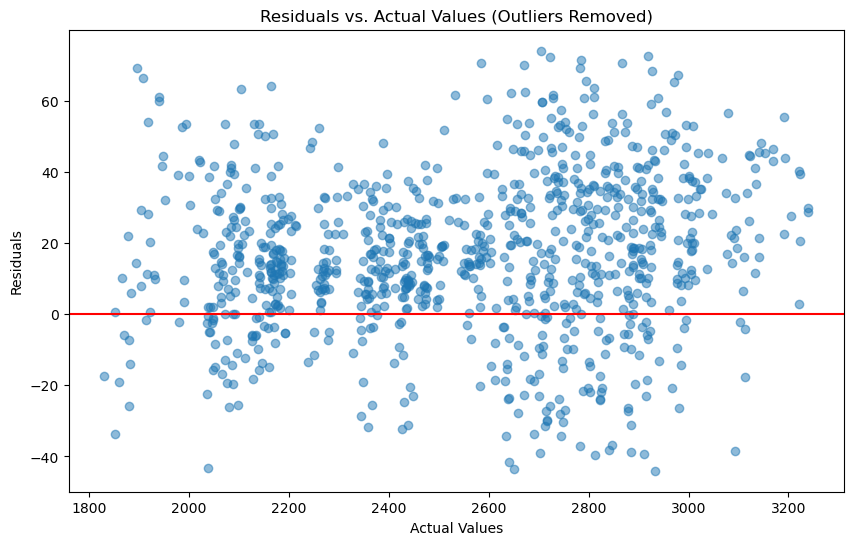

In [37]:
# Plot residuals
residuals = y_test[8:] - close_predictions

# Calculate Z-scores
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Set Z-score threshold for outliers
threshold = 2

# Remove outliers
filtered_residuals = residuals[np.abs(z_scores) < threshold]
filtered_y_open_test = y_test[8:][np.abs(z_scores) < threshold]

# Plot filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_open_test, filtered_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values (Outliers Removed)')
plt.show()

## Predict from X_test
This is the prediction using X_test which is a dataframe directly from the yahoo finance library. This means that X_test is an array with ['Open', 'High', 'Low', 'Volume'] but using real observed data, not the predictions from model 2. 

In [38]:
# Make predictions
close_predictions = close_model.best_model.predict(X_test).flatten()

32/32 [==============================] - 0s 13ms/step


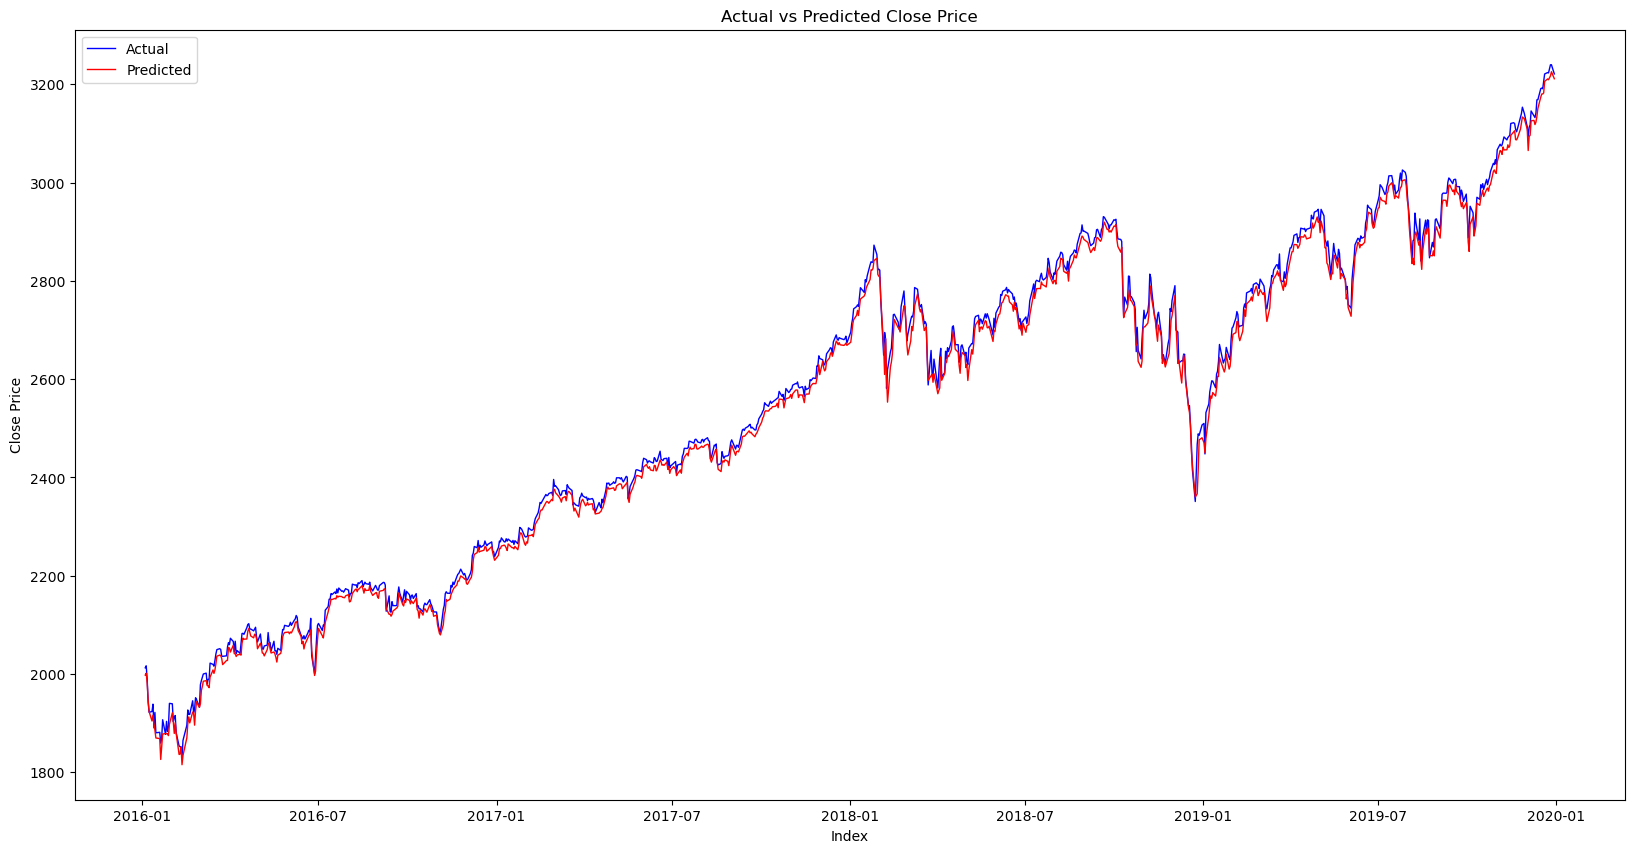

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

plt.plot(y_test.index, y_test, 'b-', label='Actual', linewidth=1)
plt.plot(y_test.index, close_predictions, 'r-', label='Predicted', linewidth=1)
plt.legend()
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.show()


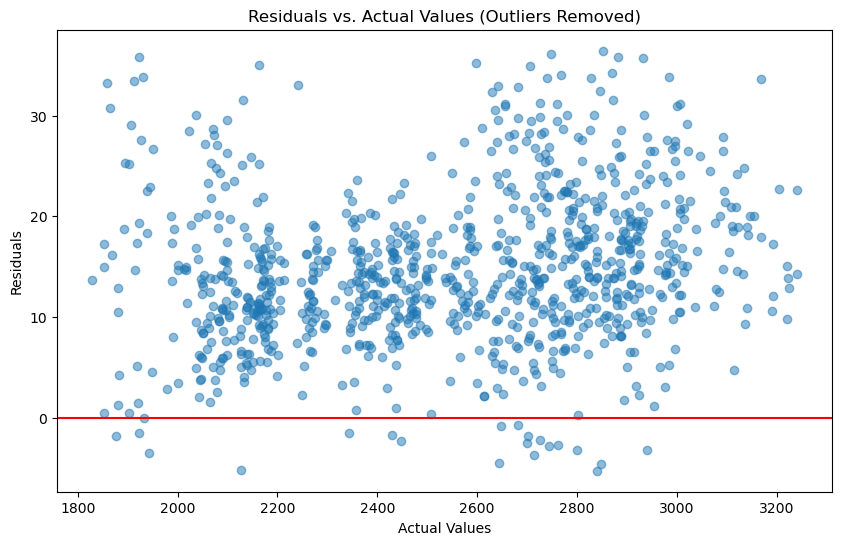

In [40]:
# Plot residuals
residuals = y_test - close_predictions

# Calculate Z-scores
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# Set Z-score threshold for outliers
threshold = 2

# Remove outliers
filtered_residuals = residuals[np.abs(z_scores) < threshold]
filtered_y_open_test = y_test[np.abs(z_scores) < threshold]

# Plot filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_y_open_test, filtered_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Values (Outliers Removed)')
plt.show()